# Example 1a: Simple Si solar cell

In this first set of examples, we will look at simple planar solar cells (Si and GaAs).

In this script, we will look at the difference between Beer-Lambert absorption calculations, using the Fresnel equations for front-surface reflection, and using the transfer-matrix model.

First, lets import some very commonly-used Python packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Numpy is a Python library which adds supports for multi-dimensional data arrays and matrices, so it is very useful for
storing and handling data. You will probably use it in every Solcore script you write. Here, it is imported under the
alias 'np', which you will see used below. matplotlib is used for making plots, and is imported under the alias 'plt'.
Both the 'np' and 'plt' aliases are extremely commonly used in Python programming.

Now, let's import some things from Solcore (which will be explained as we use them):

In [2]:
from solcore import material, si
from solcore.solar_cell import SolarCell, Layer, Junction
from solcore.solar_cell_solver import solar_cell_solver
from solcore.interpolate import interp1d

## Defining materials

To define our solar cell, we first want to define some materials. Then we want to organise those materials into Layers,
organise those layers into a Junction, and then finally define a SolarCell with that Junction.

First, let's define a Si material. Silicon, along with many other semiconductors, dielectrics, and metals common in
solar cells, is included in Solcore's database:

In [3]:
Si = material("Si")
GaAs = material("GaAs")

This creates an instance of the Si and GaAs materials. However, to use this in a solar cell we need to do specify some more
information, such as the doping level. The 'si' function comes in handy here to convert all quantities to based units
e.g. m, m^(-3)...

In [4]:
Si_n = Si(Nd=si("1e21cm-3"), hole_diffusion_length=si("10um"), relative_permittivity=11.7)
Si_p = Si(Na=si("1e16cm-3"), electron_diffusion_length=si("400um"), relative_permittivity=11.7)

## Defining layers

Now we define the emitter and base layers we will have in the solar cell; we specify their thickness, the material they
are made of and the role they play within the cell (emitter or base)

In [5]:
emitter_layer = Layer(width=si("600nm"), material=Si_n, role='emitter')
base_layer = Layer(width=si("200um"), material=Si_p, role='base')


create the p-n junction using the layers defined above. We set kind="DA" to tell Solcore to use the Depletion Approximation
in the calculation (we will discuss the different electrical solver options more later on):

In [6]:
Si_junction = Junction([emitter_layer, base_layer], kind="DA")

## Setting user options

Wavelengths we want to use in the calculations; wavelengths between 300 and 1200 nm, at 200 evenly spaced intervals:

In [7]:
wavelengths = si(np.linspace(300, 1200, 200), "nm")

Note that here and above in defining the layers and materials we have used the "si()" function: you can use this to automatically
convert quantities in other units to base SI units (e.g. nanometres to metres).

Now we specify some options for running the calculation. Initially we want to use the Beer-Lambert absorption law to
calculate the optics of the cell ("BL"). We set the wavelengths we want to use, and we set "recalculate_absorption" to
True so that further down in the script when we try different optics methods, Solcore knows we want to re-calculate the
optics of the cell. We specify the options in a Python format called a dictionary:

In [8]:
options = {
    "recalculate_absorption": True,
    "optics_method": "BL",
    "wavelength": wavelengths
           }

## Running cell simulations

Define the solar cell; in this case it is very simple and we just have a single junction:

In [9]:
solar_cell = SolarCell([Si_junction])

Now use solar_cell_solver to calculate the QE of the cell; we can ask solar_cell_solver to calculate 'qe', 'optics' or 'iv'.


In [10]:
solar_cell_solver(solar_cell, 'qe', options)

Solving optics of the solar cell...
Solving QE of the solar cell...


**PLOT 1**: plotting the QE in the Si junction, as well as the fraction of light absorbed in the junction and reflected:

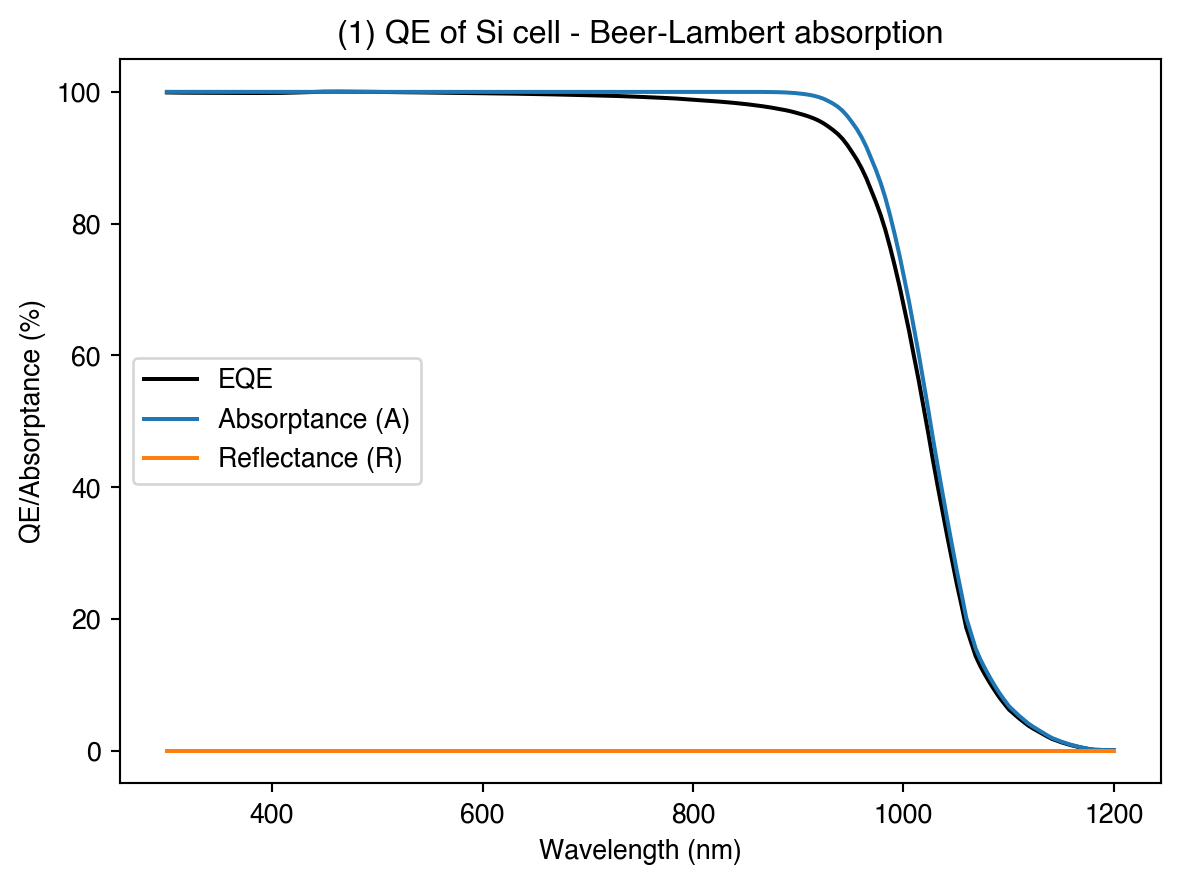

In [11]:
plt.figure()
plt.plot(wavelengths*1e9, 100*solar_cell[0].eqe(wavelengths), 'k-', label="EQE")
plt.plot(wavelengths*1e9, 100*solar_cell[0].layer_absorption, label='Absorptance (A)')
plt.plot(wavelengths*1e9, 100*solar_cell.reflected, label='Reflectance (R)')
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("QE/Absorptance (%)")
plt.title("(1) QE of Si cell - Beer-Lambert absorption")
plt.show()

## Adding front-surface reflection: Fresnel

Now, to make this calculation a bit more realistic, there are a few things we could do. We could load some measured front
surface reflectance from a file, or we could calculate the reflectance. To calculate the reflectance,
there are many approaches we could take; we are going to explore two of them here.

If we assume the silicon is infinitely thick (or at least much thicker than the wavelengths we care about) then the
reflectance will approach the reflectivity of a simple air/Si interface. We can calculate what this is using the Fresnel
equation for reflectivity: https://en.wikipedia.org/wiki/Fresnel_equations

In [12]:
def calculate_R_Fresnel(incidence_n, transmission_n, wl):
    # return a function that gives the value of R (at normal incidence) at the input wavelengths

    Rs = np.abs((incidence_n - transmission_n)/(incidence_n + transmission_n))**2

    return interp1d(wl, Rs)

complex reflective index at our wavelengths for the transmission medium (Si). The incidence_n = 1 (air).

In [13]:
trns_n = Si_n.n(wavelengths) + 1j*Si_n.k(wavelengths)
reflectivity_fn = calculate_R_Fresnel(1, trns_n, wavelengths)

we define the solar cell again, with the same layers but now supplying the function for the externally-calculated
reflectivity, and calculate the optics (reflection, absorption, transmission):

In [14]:
solar_cell_fresnel = SolarCell([Si_junction], reflectivity=reflectivity_fn)

solar_cell_solver(solar_cell_fresnel, 'optics', options)

Solving optics of the solar cell...


## Adding front surface reflection: TMM

Finally, we do the same again but now instead of supplying the external reflectivity we ask set the optics_method to
"TMM" (Transfer Matrix Method), to correctly calculate reflection at the front surface:

In [15]:
Si_junction = Junction([emitter_layer, base_layer], kind="DA")

solar_cell_TMM = SolarCell([Si_junction])

Set some more options:

In [16]:
options["optics_method"] = "TMM"
voltages = np.linspace(0, 1.1, 100)
options["light_iv"] = True
options["mpp"] = True
options["voltages"] = voltages

we calculate the QE and the IV (we set the light_iv option to True; if we don't do this, Solcore just calculates the
dark IV). We also ask Solcore to find the maximum power point (mpp) so we can get the efficiency.

In [17]:
solar_cell_solver(solar_cell_TMM, 'iv', options)
solar_cell_solver(solar_cell_TMM, 'qe', options)

Solving optics of the solar cell...
Treating layer(s) 1 incoherently
Calculating RAT...
Calculating absorption profile...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Solving optics of the solar cell...
Treating layer(s) 1 incoherently
Calculating RAT...
Calculating absorption profile...


Solving QE of the solar cell...


**PLOT 2**: here we plot the reflection, transmission, and absorption calculated with the Fresnel equation defined above,
and with the TMM solver in Solcore, showing that for this simple situation (no anti-reflection coating, thick Si junction)
they are exactly equivalent.

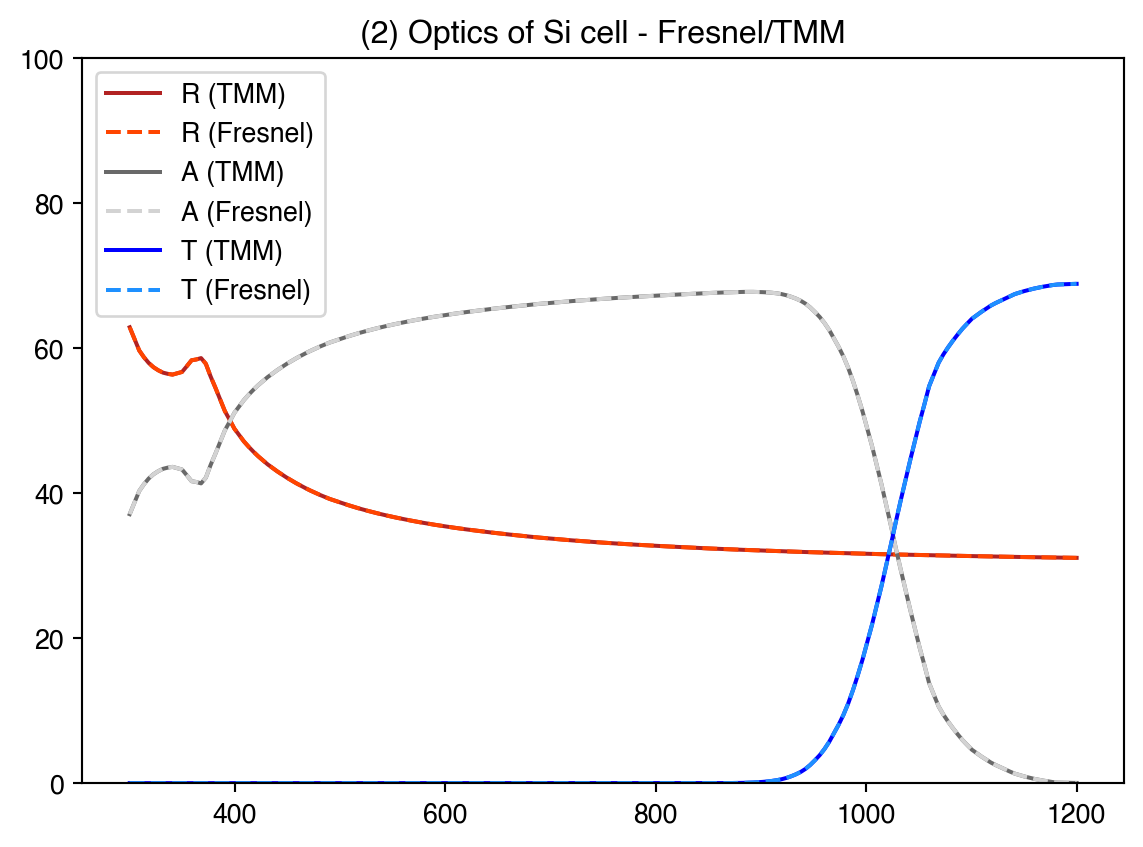

In [18]:
plt.figure()
plt.plot(wavelengths*1e9, 100*solar_cell_TMM.reflected, color='firebrick', label = "R (TMM)")
plt.plot(wavelengths*1e9, 100*solar_cell_fresnel.reflected, '--', color='orangered', label = "R (Fresnel)")
plt.plot(wavelengths*1e9, 100*solar_cell_TMM.absorbed, color='dimgrey', label = "A (TMM)")
plt.plot(wavelengths*1e9, 100*solar_cell_fresnel.absorbed, '--', color='lightgrey', label = "A (Fresnel)")
plt.plot(wavelengths*1e9, 100*solar_cell_TMM.transmitted, color='blue', label = "T (TMM)")
plt.plot(wavelengths*1e9, 100*solar_cell_fresnel.transmitted, '--', color='dodgerblue', label = "T (Fresnel)")
plt.ylim(0, 100)
plt.legend()
plt.title("(2) Optics of Si cell - Fresnel/TMM")
plt.show()

**PLOT 3**: As above for the TMM calculation, plotting the EQE as well, which will be slightly lower than the absorption
because not all the carriers are collected. Comparing to plot (1), we can see we now have lower absorption due to
the inclusion of front surface reflection.

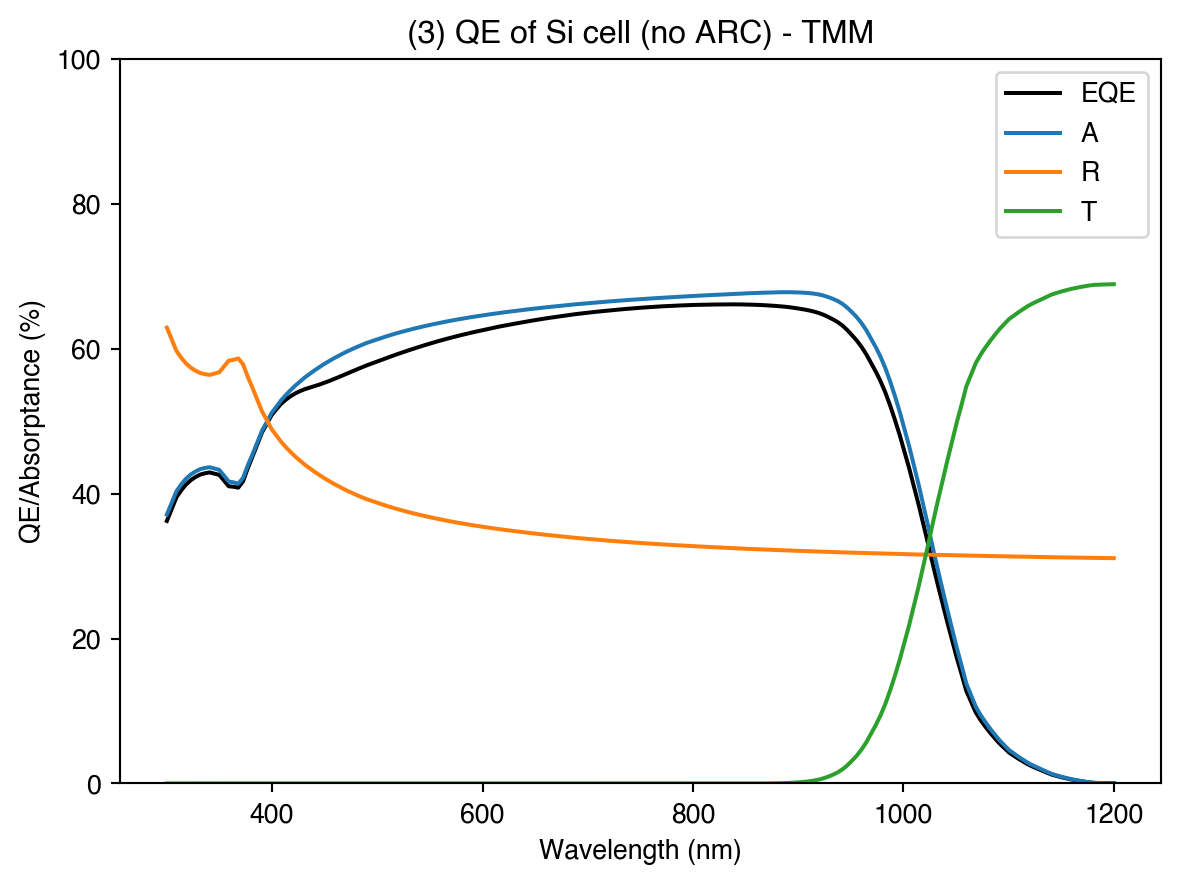

In [19]:
plt.figure()
plt.plot(wavelengths*1e9, 100*solar_cell_TMM[0].eqe(wavelengths), 'k-', label="EQE")
plt.plot(wavelengths*1e9, 100*solar_cell_TMM[0].layer_absorption, label='A')
plt.plot(wavelengths*1e9, 100*solar_cell_TMM.reflected, label="R")
plt.plot(wavelengths*1e9, 100*solar_cell_TMM.transmitted, label="T")
plt.title("(3) QE of Si cell (no ARC) - TMM")
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("QE/Absorptance (%)")
plt.ylim(0, 100)
plt.show()

## Adding an ARC

Now we will try adding a simple anti-reflection coating (ARC), a single layer of silicon nitride (Si3N4):

In [20]:
SiN = material("Si3N4")()

Si_junction = Junction([emitter_layer, base_layer], kind="DA")

solar_cell_TMM_ARC = SolarCell([Layer(width=si(75, "nm"), material=SiN), Si_junction])

solar_cell_solver(solar_cell_TMM_ARC, 'qe', options)
solar_cell_solver(solar_cell_TMM_ARC, 'iv', options)

Solving optics of the solar cell...
Treating layer(s) 2 incoherently
Calculating RAT...
Calculating absorption profile...
Solving QE of the solar cell...


Solving optics of the solar cell...
Treating layer(s) 2 incoherently
Calculating RAT...
Calculating absorption profile...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


**PLOT 4**: Absorption, EQE, reflection and transmission for the cell with a simple one-layer ARC. We see the reflection
is significantly reduced from the previous plot leading to higher absorption/EQE.

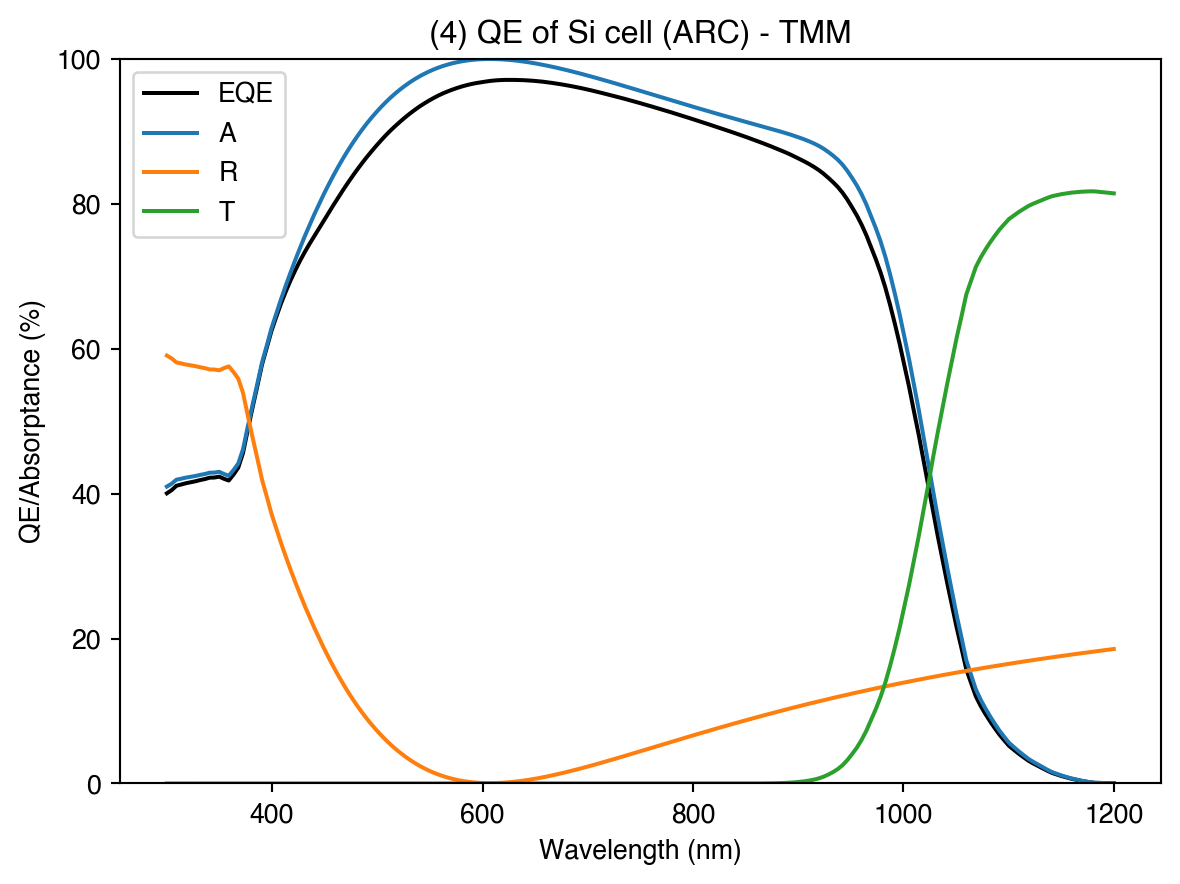

In [21]:
plt.figure()
plt.plot(wavelengths*1e9, 100*solar_cell_TMM_ARC[1].eqe(wavelengths), 'k-', label="EQE")
plt.plot(wavelengths*1e9, 100*solar_cell_TMM_ARC[1].layer_absorption, label='A')
plt.plot(wavelengths*1e9, 100*solar_cell_TMM_ARC.reflected, label="R")
plt.plot(wavelengths*1e9, 100*solar_cell_TMM_ARC.transmitted, label="T")
plt.legend()
plt.title("(4) QE of Si cell (ARC) - TMM")
plt.xlabel("Wavelength (nm)")
plt.ylabel("QE/Absorptance (%)")
plt.ylim(0, 100)
plt.show()

**PLOT 5**: Compare the IV curves of the cells with and without an ARC. The efficiency is also shown on the
plot. Note that because we didn't specify a light source, Solcore will assume we want to use AM1.5G; in later
examples we will set the light source used for IV simulations explicitly.


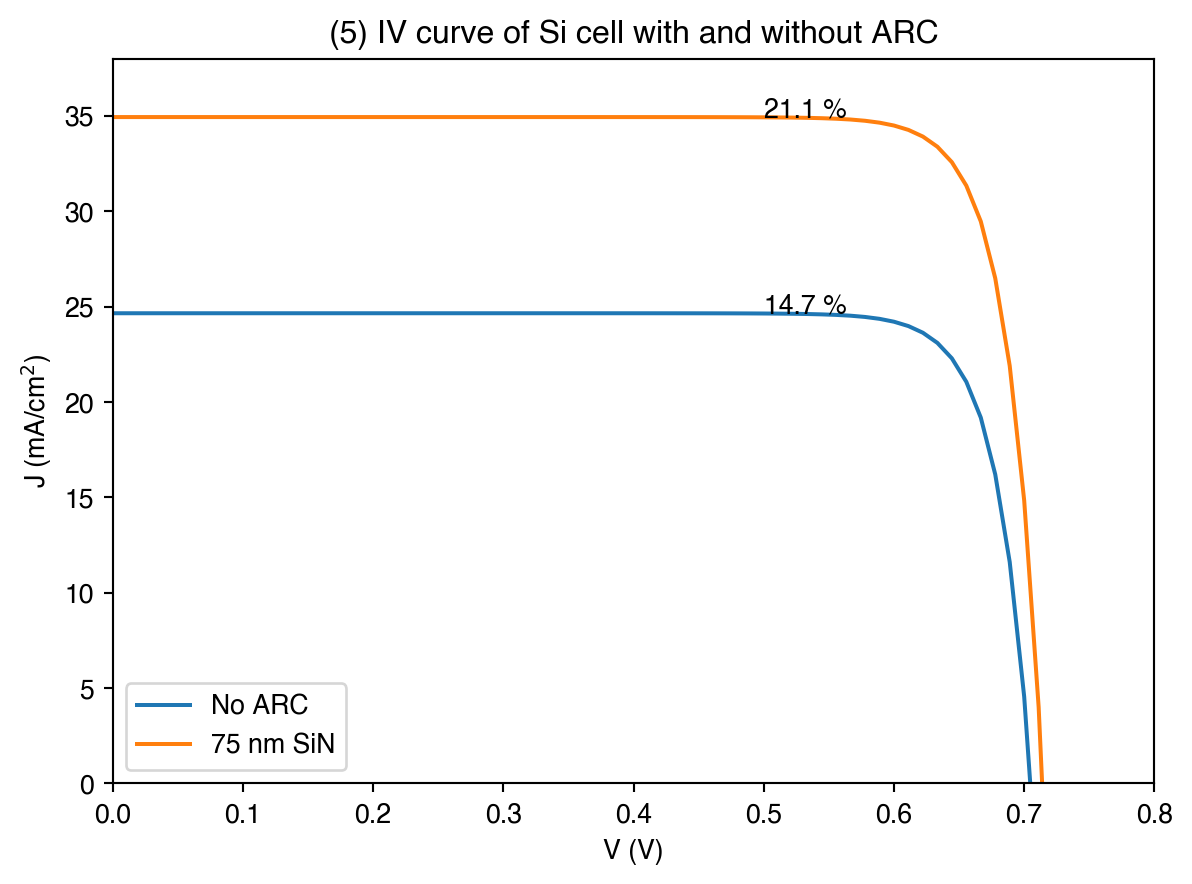

In [22]:
plt.figure()
plt.plot(voltages, -solar_cell_TMM[0].iv(voltages)/10, label="No ARC")
plt.plot(voltages, -solar_cell_TMM_ARC[1].iv(voltages)/10, label="75 nm SiN")
plt.text(0.5, solar_cell_TMM.iv["Isc"]/10, str(round(solar_cell_TMM.iv["Eta"]*100, 1)) + ' %')
plt.text(0.5, solar_cell_TMM_ARC.iv["Isc"]/10, str(round(solar_cell_TMM_ARC.iv["Eta"]*100, 1)) + ' %')
plt.ylim(0, 38)
plt.xlim(0, 0.8)
plt.legend()
plt.xlabel("V (V)")
plt.ylabel(r"J (mA/cm$^2$)")
plt.title("(5) IV curve of Si cell with and without ARC")
plt.show()

## Conclusions

We see that the cell with an ARC has a significantly higher Jsc, and a slightly higher Voc,
than the bare Si cell. In reality, most Si cells have a textured surface rather than a planar
surface with an ARC; this will be discussed later in the course.

Overall, some things we can take away from the examples in this script:
- The Beer-Lambert law is a very simple way to calculate absorption in a cell, but won't take into
  account important effects such as front-surface reflection or the effects of anti-reflection coatings
- Using the transfer-matrix method (TMM) we can account for front surface reflection and interference
  effects which make e.g. ARCs effective. In the simple situation of a thick cell without any front surface
  layers, it is equivalent to simply calculation the reflection with the Fresnel equations and assuming
  Beer-Lambert absorption in the cell.
- Adding a simple, one-layer ARC can significantly reduce front-surface reflection for a single-junction
  cell, leading to improved short-circuit current.